In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import csv

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [4]:
train_df = df.loc[:20896]
val_df = df.loc[20897:].reset_index(drop = True)

In [5]:
train_df['image_id'] = '../input/cassava-leaf-disease-classification/train_images'+os.sep + train_df['image_id']
val_df['image_id'] = '../input/cassava-leaf-disease-classification/train_images'+os.sep + val_df['image_id']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
train_files_ds = tf.data.Dataset.from_tensor_slices((train_df['image_id'],train_df['label']))
val_files_ds = tf.data.Dataset.from_tensor_slices((val_df['image_id'],val_df['label']))

2021-11-08 12:42:17.676973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 12:42:17.765731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 12:42:17.766527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 12:42:17.767934: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
def handle_filenames(filename,label):
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image,channels = 3)
    image = tf.image.resize(image,size = (224,224))
    return image,label
auto = tf.data.experimental.AUTOTUNE

train_ds = train_files_ds.map(handle_filenames).batch(10).prefetch(auto)
val_ds = val_files_ds.map(handle_filenames).batch(10).prefetch(auto)

2021-11-08 12:42:19.961108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


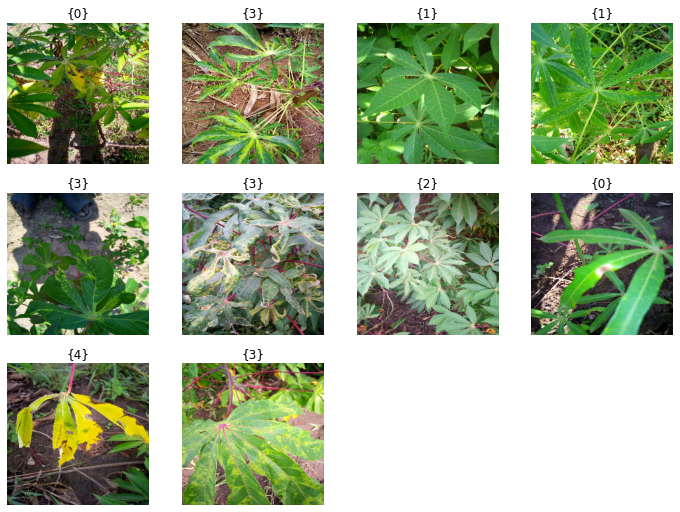

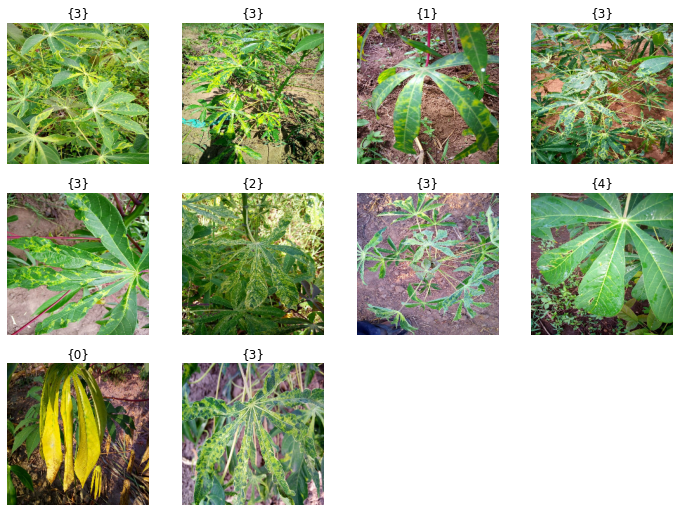

In [8]:
def show(images,labels):
    plt.figure(figsize=(12, 12))
    for it, (image, label) in enumerate(zip(images[:10], labels[:10])):
        plt.subplot(4, 4, it+1)
        plt.imshow(image/255.0)
        plt.axis('off')
        plt.title({int(label)})
for i in train_ds.take(2):
    show(i[0],i[1])

In [9]:
preprocess = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomZoom((-0.2, 0)),
    layers.RandomContrast((0.2,0.2))
])

#vit_backbone = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b8_fe/1", trainable=False) 
backbone = keras.applications.EfficientNetB3(
    include_top = False,
    weights = '../input/efficientnetb3-notop/efficientnetb3_notop.h5',
    input_shape = (224,224,3)
)
resnet_preprocess = keras.applications.efficientnet.preprocess_input
backbone.trainable = True

In [10]:
inp = keras.Input(shape = (224,224,3))
x = preprocess(inp)
x = resnet_preprocess(x)
x = backbone(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(5,activation = 'softmax')(x)
model = keras.Model(inp,x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [11]:
LR_START = 0.0001
LR_MAX = 0.001 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [12]:
decay_steps = int(round(len(train_df)/10))*10
cosine_decay = keras.experimental.CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

In [13]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.Adam(cosine_decay),
    metrics = ['accuracy']
)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5
)
model.fit(train_ds,
          validation_data = val_ds,
          epochs = 30,
          callbacks = [early_stopping])

Epoch 1/30


2021-11-08 12:42:42.285378: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2090/2090 [==============================] - 407s 185ms/step - loss: 0.6908 - accuracy: 0.7520 - val_loss: 0.6894 - val_accuracy: 0.7360
Epoch 2/30
2090/2090 [==============================] - 382s 183ms/step - loss: 0.5247 - accuracy: 0.8145 - val_loss: 0.6393 - val_accuracy: 0.7680
Epoch 3/30
2090/2090 [==============================] - 384s 184ms/step - loss: 0.4543 - accuracy: 0.8399 - val_loss: 0.4865 - val_accuracy: 0.8340
Epoch 4/30
2090/2090 [==============================] - 388s 186ms/step - loss: 0.4029 - accuracy: 0.8592 - val_loss: 0.5077 - val_accuracy: 0.8080
Epoch 5/30
2090/2090 [==============================] - 387s 185ms/step - loss: 0.3541 - accuracy: 0.8723 - val_loss: 0.5612 - val_accuracy: 0.7880
Epoch 6/30
2090/2090 [==============================] - 391s 187ms/step - loss: 0.3051 - accuracy: 0.8905 - val_loss: 0.5267 - val_accuracy: 0.8100
Epoch 7/30
2090/2090 [==============================] - 388s 186ms/step - loss: 0.2603 - accuracy: 0.9070 - val_loss: 0.578

In [15]:
model.save('model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
l = os.listdir("../input/cassava-leaf-disease-classification/test_images")
parent = "../input/cassava-leaf-disease-classification/test_images/"
predictions = []
predictions.append(["image_id", "label"])
for i in l :
    child = parent + i
    img = cv2.imread(child)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = img.reshape((1, 224, 224, 3))
    pred = model.predict(img)
    pred = pred.reshape((5,))
    print(np.argmax(pred))
    del img
    predictions.append([i, str(np.argmax(pred))])
    del pred


with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(predictions)

2


In [17]:
pd.read_csv('submission.csv')

,image_id,label
0,2216849948.jpg,2
